In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score,classification_report

#  Data Presentation and Formulation of the Problem

## 🔍 The Problem:

* The company needs to reduce its costs in the face of the drop in the value of pulp in the international market.
* One of the fronts in this endeavor is to reduce the maintenance costs of its assets, making it more precise and objective, working within what is necessary, without this harming production, of course.

## 🎲 The Data:

* For this purpose, the maintenance team provided us with a historical series of each asset that failed at some point, totaling 100 assets, and another table with another 100 assets to test the model's fidelity.  

## 🎯 The main goal is to evaluate the feasibility of a model capable of predicting the maintenance of each asset 20 cycles in advance.

## 🚀 The Results:

* It was possible to create two models with the prediction of up to 20 cycles in advance of equipment failure.
* These two models have different principles and therefore can generate different results depending on the objective.
* There is not enough data and information to objectively calculate the cost savings and define which is the best model.

# Importing the data

## Checking dimension, structure, length of the data and loading it

Here I will use a shell-Linux command to check the first 3 lines of the file and the length of the document 🔍

In [2]:
!head --lines=3 ../raw_data/PM_train.txt

1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  
1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82 1403.14 14.62 21.61 553.75 2388.04 9044.07 1.30 47.49 522.28 2388.07 8131.49 8.4318 0.03 392 2388 100.00 39.00 23.4236  
1 3 -0.0043 0.0003 100.0 518.67 642.35 1587.99 1404.20 14.62 21.61 554.26 2388.08 9052.94 1.30 47.27 522.42 2388.03 8133.23 8.4178 0.03 390 2388 100.00 38.95 23.3442  


In [3]:
!wc --lines ../raw_data/PM_train.txt

20631 ../raw_data/PM_train.txt


The data structure is a text file with a visual pattern: for each variable value, it is separated by a blank space, and at the end of each observation a line break, the `read_csv()` can do the job with the separator specified:

In [4]:
# define column names for easy indexing
index_names = ['Asset id', 'runtime']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['Tag'+str(n) for n in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train_data = pd.read_csv('../raw_data/PM_train.txt', sep='\s+', header=None, names=col_names)
test_data = pd.read_csv('../raw_data/PM_test.txt', sep='\s+', header=None, names=col_names)

train_data.head()

Asset id  runtime  setting_1  setting_2  setting_3    Tag1    Tag2  \
0         1        1    -0.0007    -0.0004      100.0  518.67  641.82   
1         1        2     0.0019    -0.0003      100.0  518.67  642.15   
2         1        3    -0.0043     0.0003      100.0  518.67  642.35   
3         1        4     0.0007     0.0000      100.0  518.67  642.35   
4         1        5    -0.0019    -0.0002      100.0  518.67  642.37   

      Tag3     Tag4   Tag5  ...   Tag12    Tag13    Tag14   Tag15  Tag16  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   0.03   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   0.03   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   0.03   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   0.03   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   0.03   

   Tag17  Tag18  Tag19  Tag20    Tag21  
0    392   2388  100.0  39.06  23.4190  
1    392   2388  100.0  39.00  23.4236  
2    390   2388  100.0  38.95  23.3442  
3    392   2388  100.0  38.88  23.3739  
4    393   2388  100.0  38.90  23.4044  

[5 rows x 26 columns]

# 📊 Exploratory Data Analysis

Understanding and visualizing the data

In [5]:
# This is an automated exploratory analysis with Pandas profiling package, 
# these reports will be available in the repo for more detailed summary statistics

# profile_test = test_data.profile_report(title='Report for test data')
# profile_test.to_file(output_file='../reports/test_data.html')

🤓 So we have this table:
* The identification of each asset
* A runtime counter
* The settings used
* And the measurement of 21 sensors in each of these assets

In [6]:
# define column names for easy indexing
index_names = ['Asset id', 'runtime']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['Tag'+str(n) for n in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train_data = pd.read_csv('../raw_data/PM_train.txt', sep='\s+', header=None, names=col_names)
test_data = pd.read_csv('../raw_data/PM_test.txt', sep='\s+', header=None, names=col_names)

train_data.head()

Asset id  runtime  setting_1  setting_2  setting_3    Tag1    Tag2  \
0         1        1    -0.0007    -0.0004      100.0  518.67  641.82   
1         1        2     0.0019    -0.0003      100.0  518.67  642.15   
2         1        3    -0.0043     0.0003      100.0  518.67  642.35   
3         1        4     0.0007     0.0000      100.0  518.67  642.35   
4         1        5    -0.0019    -0.0002      100.0  518.67  642.37   

      Tag3     Tag4   Tag5  ...   Tag12    Tag13    Tag14   Tag15  Tag16  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   0.03   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   0.03   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   0.03   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   0.03   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   0.03   

   Tag17  Tag18  Tag19  Tag20    Tag21  
0    392   2388  100.0  39.06  23.4190  
1    392   2388  100.0  39.00  23.4236  
2    390   2388  100.0  38.95  23.3442  
3    392   2388  100.0  38.88  23.3739  
4    393   2388  100.0  38.90  23.4044  

[5 rows x 26 columns]

## 🆔 ⏳ Assets and Runtimes

We have 20631 observations, each one related to an asset execution.

Let's visualize the number of operations performed for each asset and observe some general statistics about it.

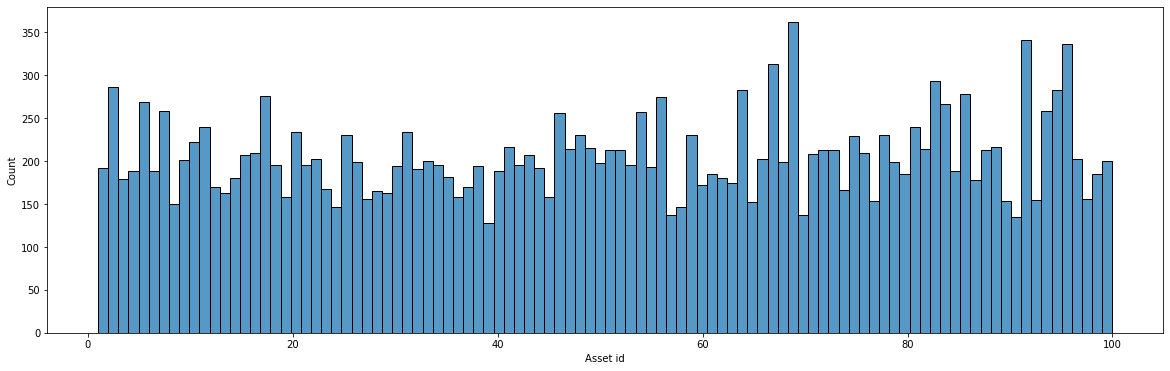

In [37]:
# Let's plot the distribution for each asset, this represents the duration of each before it crashes
plt.figure(figsize=(20,6))
sns.histplot(x='Asset id',
             data=train_data,
             bins=100);

In [8]:
# Here we can observe the minimum, maximum and average duration for each asset

train_data[index_names].groupby('Asset id').max().describe()

runtime
count  100.000000
mean   206.310000
std     46.342749
min    128.000000
25%    177.000000
50%    199.000000
75%    229.250000
max    362.000000

The statistics suggest that, on average, assets last between 199 and 209 runtimes. We can also see that the asset that failed the earliest was consumed only 128 times, and the longest was used 362 times.

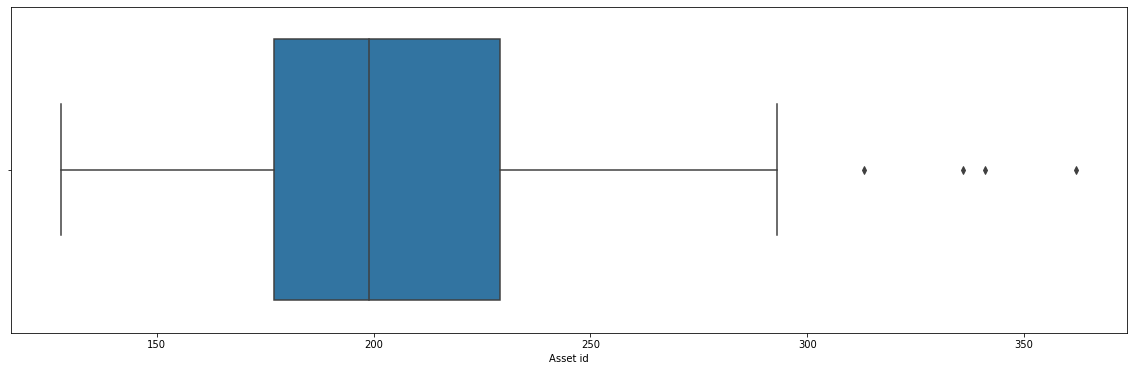

In [38]:
# As always, it's better when visualized

plt.figure(figsize=(20,6))
sns.boxplot(x=train_data['Asset id'].value_counts());

## ⚙️ Settings

The second layer of the dataset is the Settings used to run each asset, let's see:

In [10]:
# Summary
train_data[setting_names].describe()

setting_1     setting_2  setting_3
count  20631.000000  20631.000000    20631.0
mean      -0.000009      0.000002      100.0
std        0.002187      0.000293        0.0
min       -0.008700     -0.000600      100.0
25%       -0.001500     -0.000200      100.0
50%        0.000000      0.000000      100.0
75%        0.001500      0.000300      100.0
max        0.008700      0.000600      100.0

As we can see from the standard deviation, there are no considerable changes in the settings pattern. This suggests (and only suggests as we don't have more details on what exactly these settings are) that the assets are used within a stable production line with little variation.

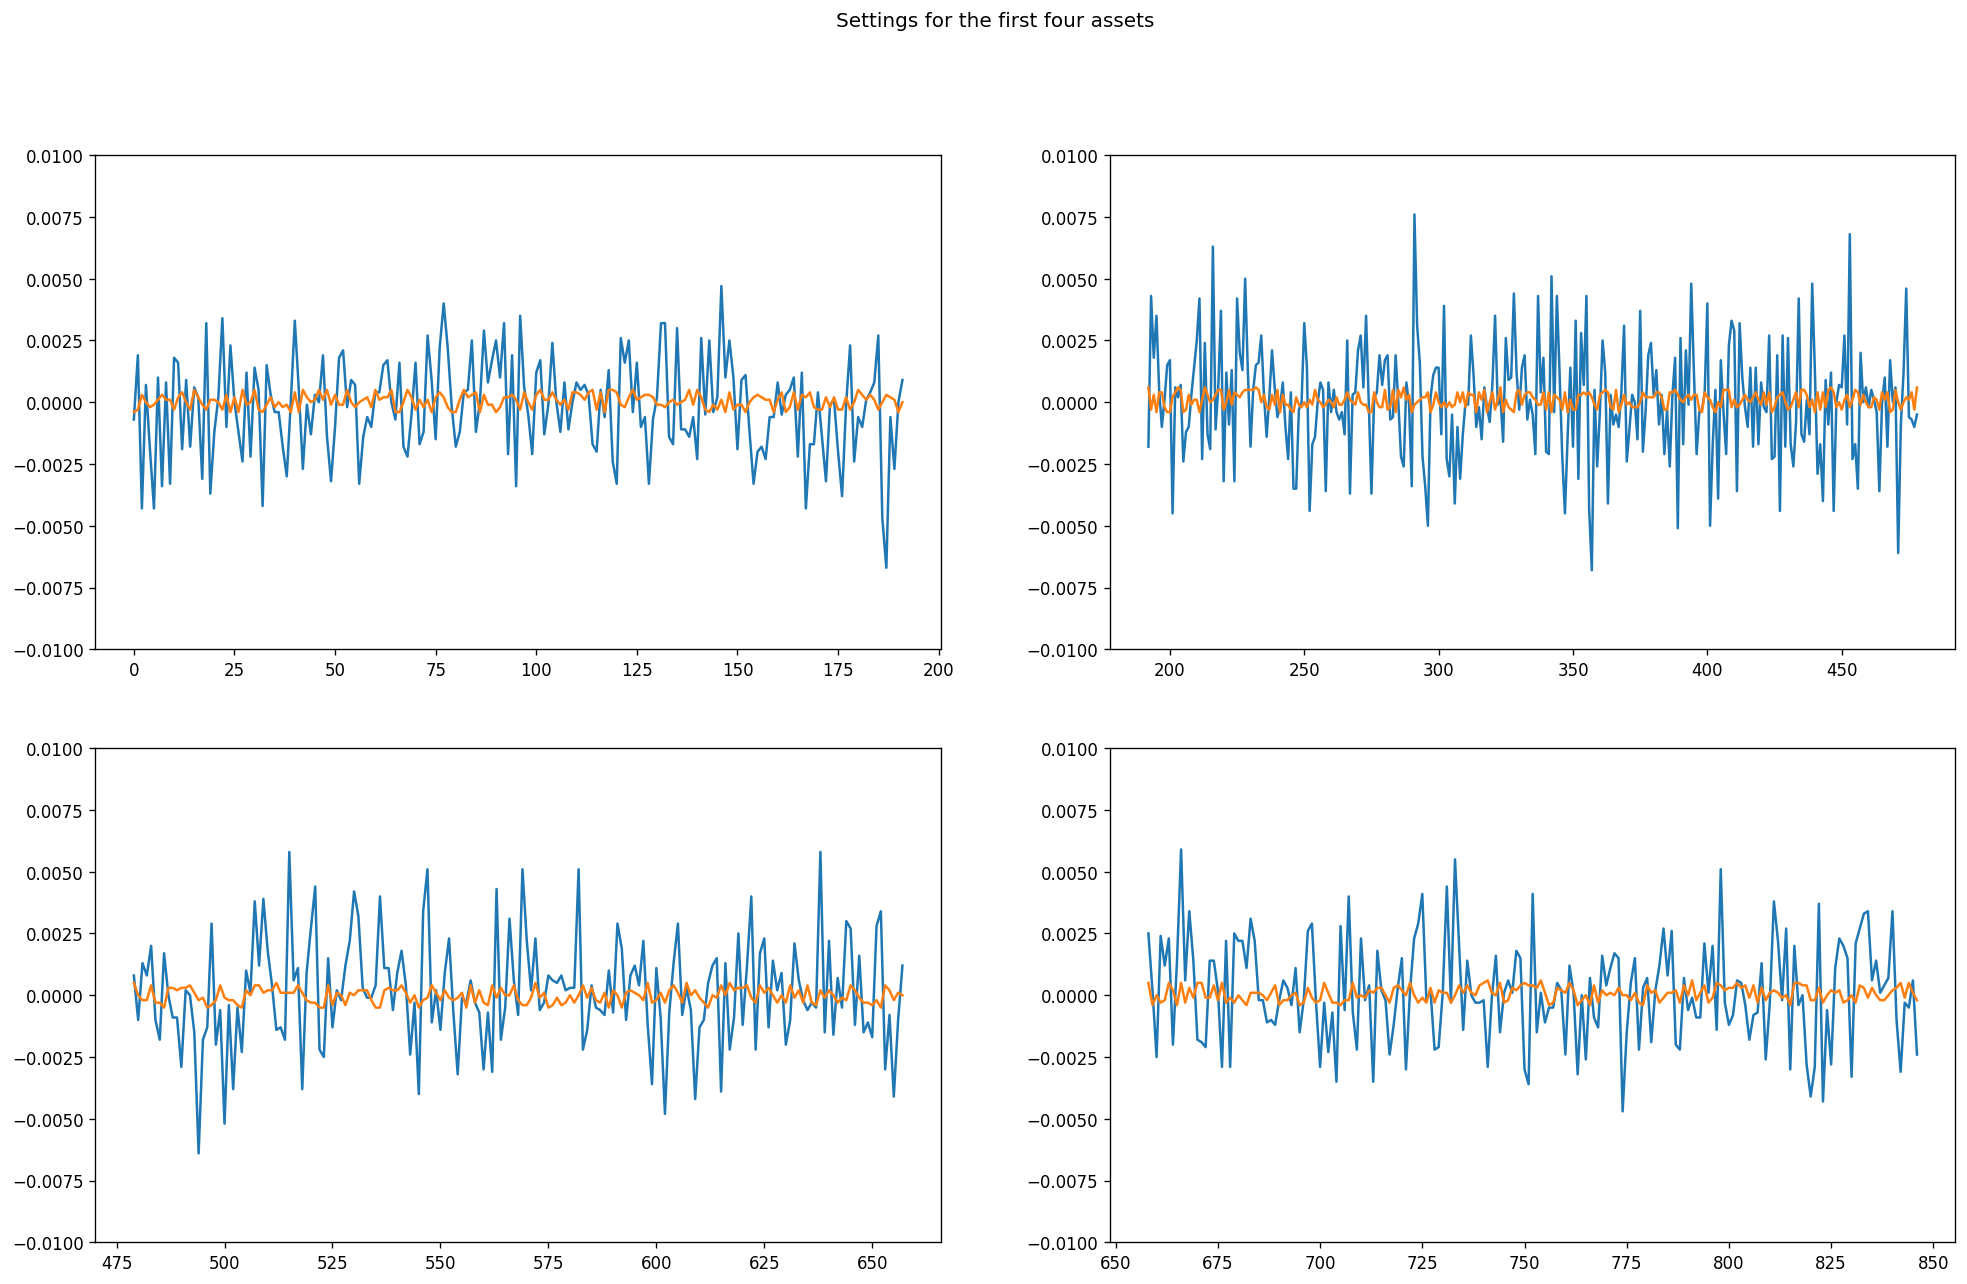

In [39]:
# For visualization purpose I will plot the first four assets settings
# I know, I know, we need more colorful insights here, but time is short

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,12), dpi=120)
fig.suptitle('Settings for the first four assets')
ax1.plot(train_data.loc[train_data['Asset id'] == 1]['setting_1'])
ax1.plot(train_data.loc[train_data['Asset id'] == 1]['setting_2'])
ax1.set_ylim(-0.01, 0.01)
ax2.plot(train_data.loc[train_data['Asset id'] == 2]['setting_1'])
ax2.plot(train_data.loc[train_data['Asset id'] == 2]['setting_2'])
ax2.set_ylim(-0.01, 0.01)
ax3.plot(train_data.loc[train_data['Asset id'] == 3]['setting_1'])
ax3.plot(train_data.loc[train_data['Asset id'] == 3]['setting_2'])
ax3.set_ylim(-0.01, 0.01)
ax4.plot(train_data.loc[train_data['Asset id'] == 4]['setting_1'])
ax4.plot(train_data.loc[train_data['Asset id'] == 4]['setting_2'])
ax4.set_ylim(-0.01, 0.01);

## 🏷️ Tags

Last but not least we have all the 21 tags representing the reading of each monitoring sensor of the asset, let's take a look:

In [12]:
train_data[sensor_names].describe().T

count         mean           std        min        25%        50%  \
Tag1   20631.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
Tag2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
Tag3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
Tag4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
Tag5   20631.0    14.620000  1.776400e-15    14.6200    14.6200    14.6200   
Tag6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
Tag7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
Tag8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
Tag9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
Tag10  20631.0     1.300000  0.000000e+00     1.3000     1.3000     1.3000   
Tag11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
Tag12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
Tag13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
Tag14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
Tag15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
Tag16  20631.0     0.030000  1.387812e-17     0.0300     0.0300     0.0300   
Tag17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
Tag18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
Tag19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
Tag20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
Tag21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

             75%        max  
Tag1    518.6700   518.6700  
Tag2    643.0000   644.5300  
Tag3   1594.3800  1616.9100  
Tag4   1414.5550  1441.4900  
Tag5     14.6200    14.6200  
Tag6     21.6100    21.6100  
Tag7    554.0100   556.0600  
Tag8   2388.1400  2388.5600  
Tag9   9069.4200  9244.5900  
Tag10     1.3000     1.3000  
Tag11    47.7000    48.5300  
Tag12   521.9500   523.3800  
Tag13  2388.1400  2388.5600  
Tag14  8148.3100  8293.7200  
Tag15     8.4656     8.5848  
Tag16     0.0300     0.0300  
Tag17   394.0000   400.0000  
Tag18  2388.0000  2388.0000  
Tag19   100.0000   100.0000  
Tag20    38.9500    39.4300  
Tag21    23.3668    23.6184

It's a little messy to analyze all those numbers, let's make some viz

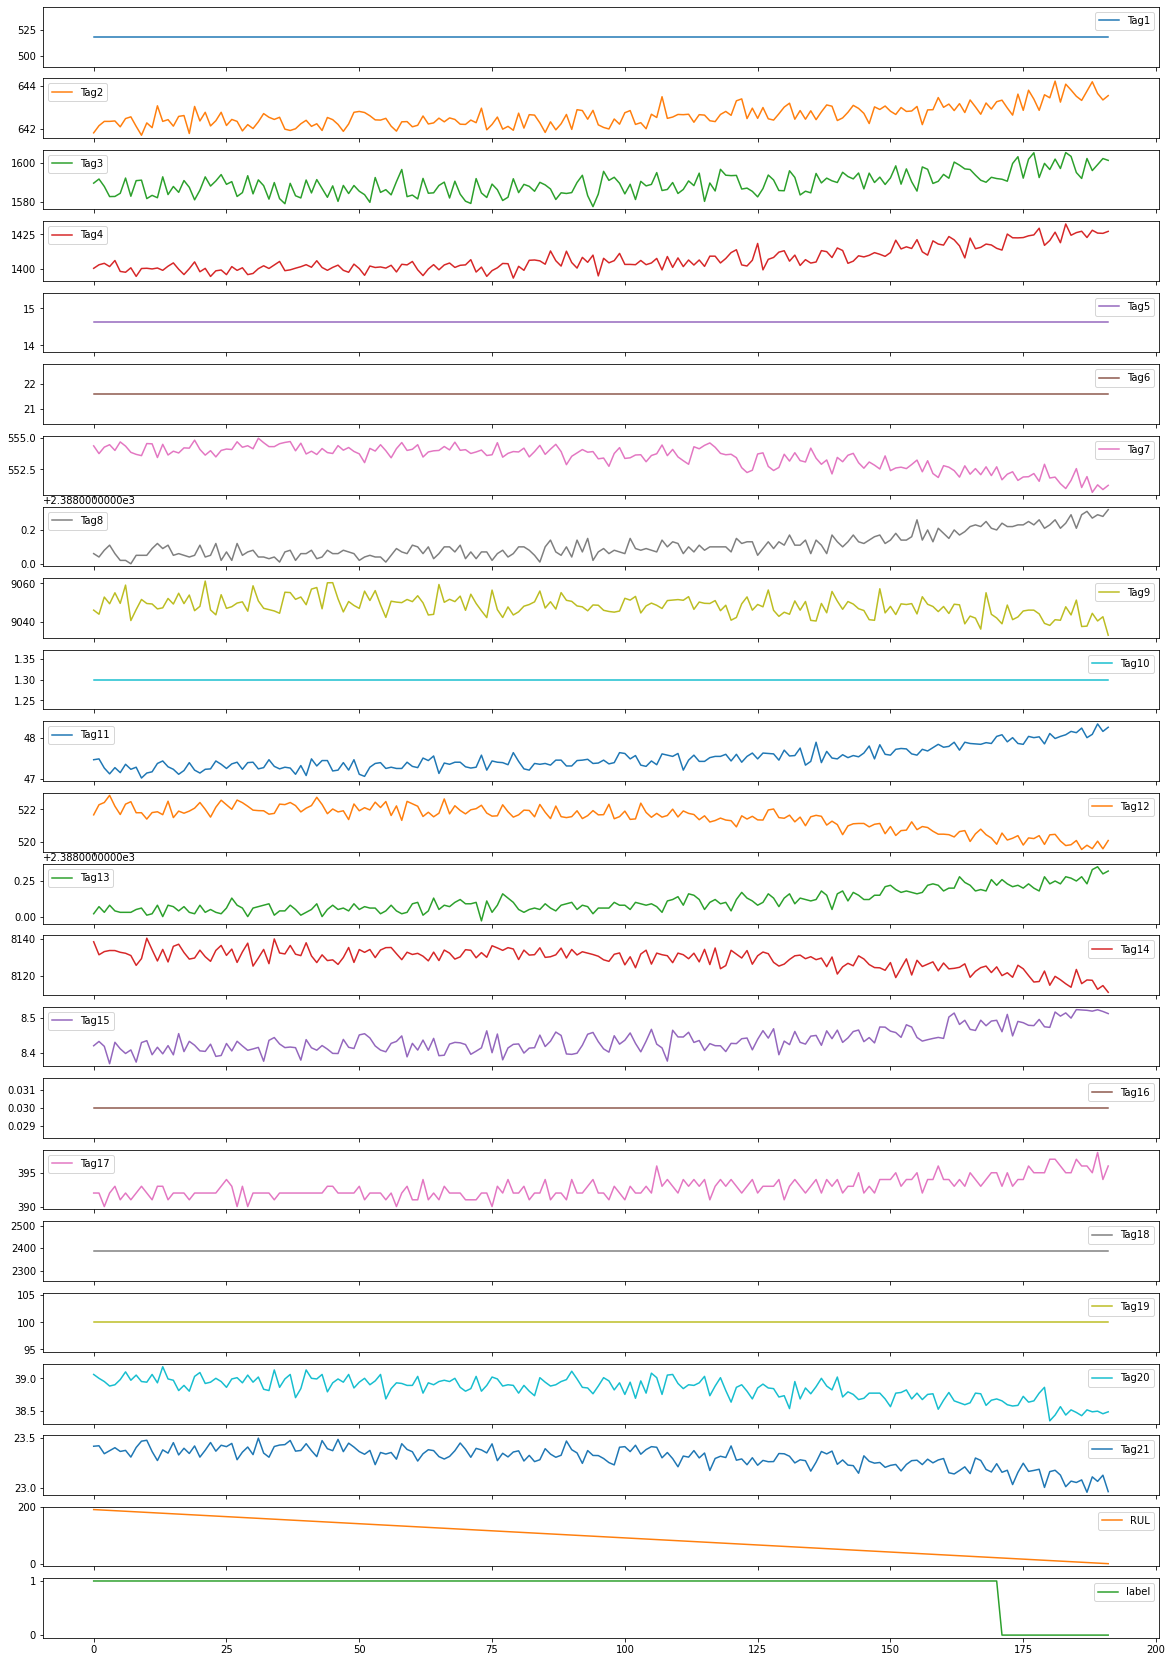

In [40]:
train_data.loc[train_data['Asset id'] == 1].iloc[:,5:].plot(subplots=True, sharex=True, figsize=(20,30));

👀 So, what can we intuit from the combination of the statistical summary and the visualization of the sensors for each asset? 
1. There is no variation for some sensors (`Tag1`, `Tag10`, `Tag18` and `Tag19`) along the data, as we can see by the recurrence of one same value with no standard deviation associated, so maybe we can drop them out to preserve only useful information and prevent further model overfitting.
2. In this visualization for the first asset sensors, we can see a tendency in the variation indicating a future failure, usually in the final quarter of the data. This is a good indication that there is a pattern that the model can rely on to make the prediction.

## 💀 Remaining Useful Life (RUL)

To advance the analysis and the possibility of prediction, we can use the concept of remaining useful life - RUL. It will work as a coefficient to indicate how many cycles each asset has to failure, like a countdown. To calculate it is simple: as we already have information about the useful life of each of the assets, we just have to invert the count.

And we have the following distribution:

In [14]:
# Computing RUL for eache runtime

train_data['RUL'] = train_data.groupby(['Asset id'])['runtime'].transform(max) - train_data['runtime']

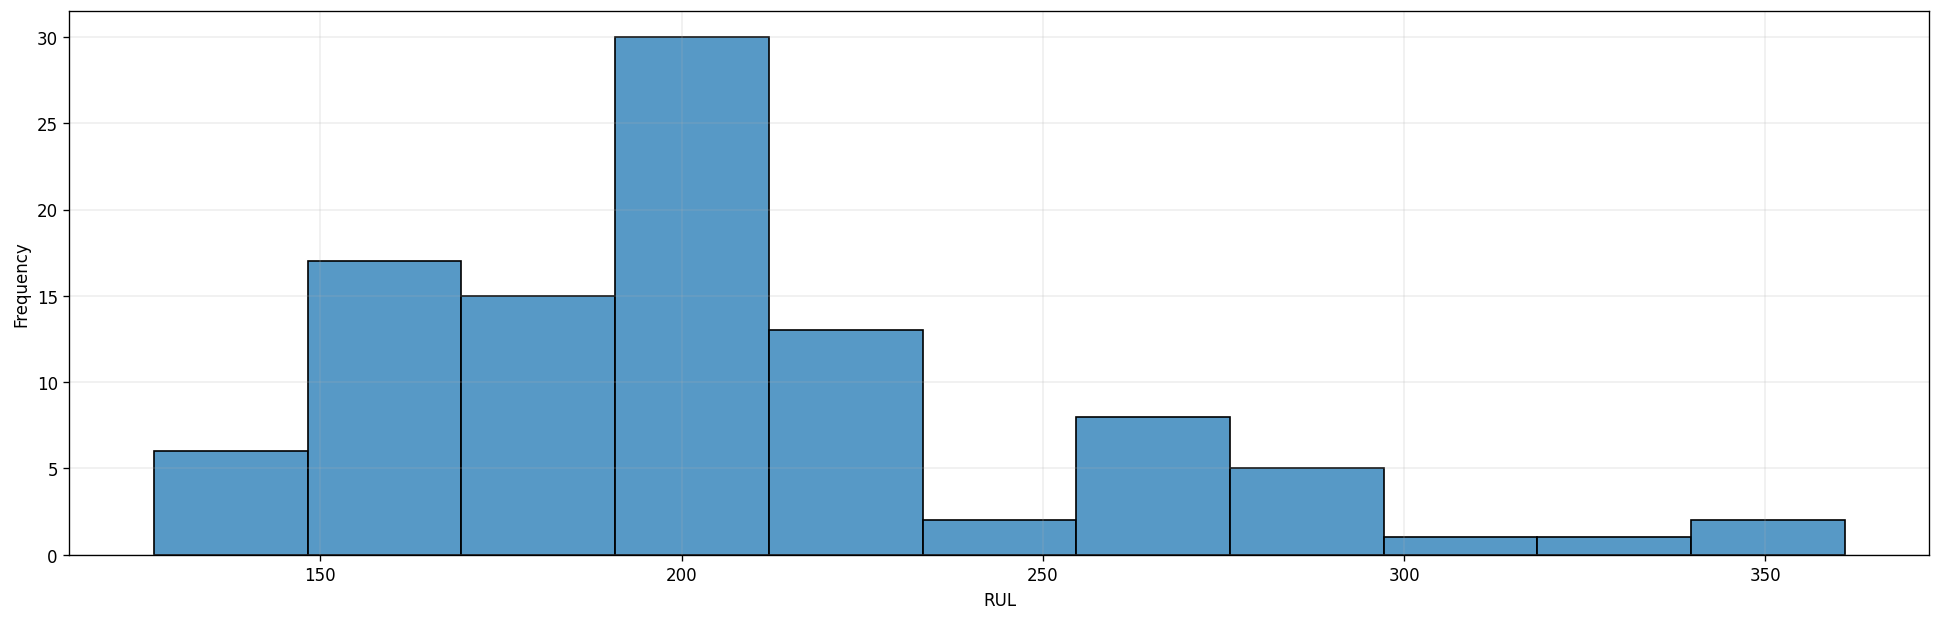

In [41]:
plt.figure(figsize=(20,6), dpi=120)
sns.histplot(x=train_data[['Asset id', 'RUL']].groupby('Asset id').max().reset_index()['RUL'])
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.grid(axis="both", linewidth=0.2)
plt.show();

In [16]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(12, 3), dpi=120)
    for i in train_data['Asset id'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL',
                     sensor_name,
                     data=train_data[train_data['Asset id'] == i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()
    
for sensor_name in sensor_names:
    plot_sensor(sensor_name)

/tmp/ipykernel_12692/1838057726.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 3), dpi=120)


Or, we can also work with the RUL to better visualize the correlation between the sensor data and the failure.

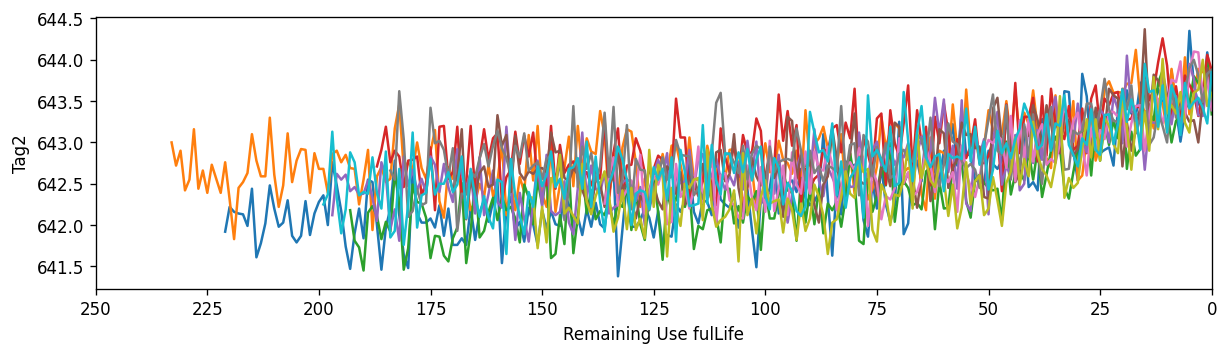

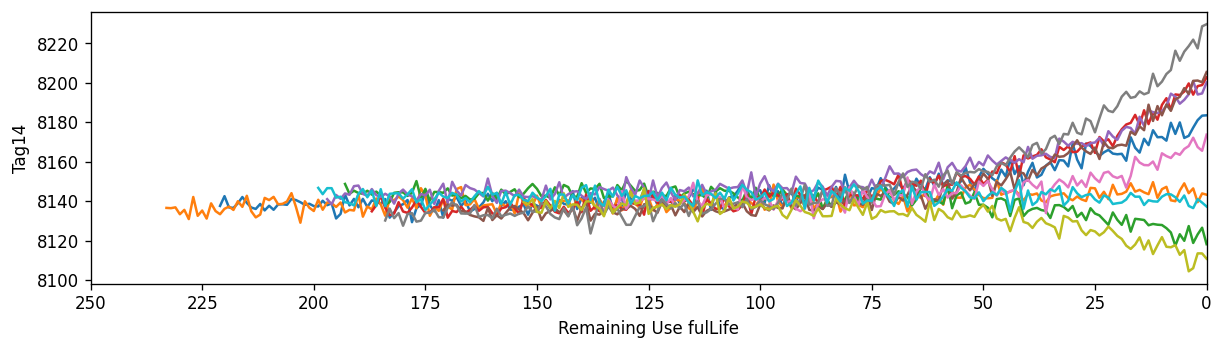

In [42]:
sensors_1 = ['Tag2', 'Tag14']

for sensor_name in sensors_1:
    plot_sensor(sensor_name)

We can also observe which sensors do not add relevant information to the construction of a linear model.

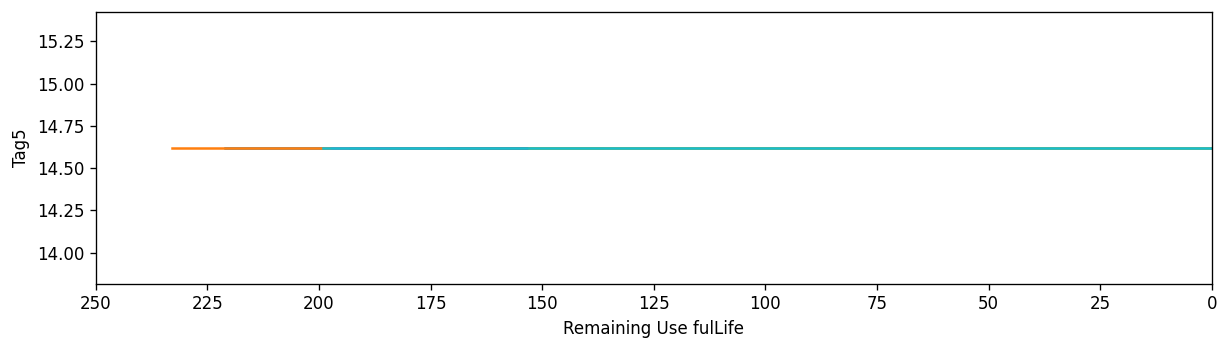

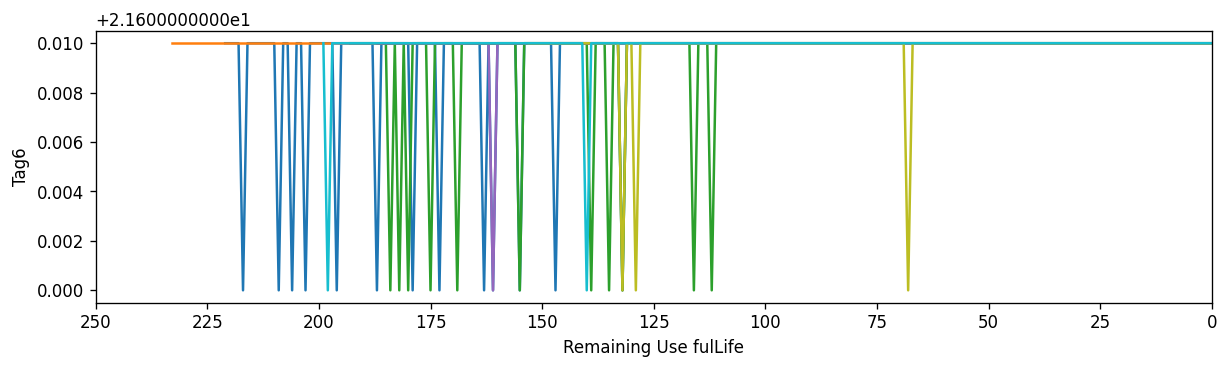

In [43]:
sensors_2 = ['Tag5', 'Tag6']

for sensor_name in sensors_2:
    plot_sensor(sensor_name)

## Conclusions 🤔

✅ There is a normalized distribution for the assets, indicating that we can make a statistical inference on the lifetime of the equipment.

✅ Settings have little or no impact on building a predictive model.

✅ We can use RUL calculation to correlate variables and predict future failure.

✅ Some sensors present irrelevant data for the construction of a linear model, which we will discard at first.

# 🧠 Modeling

There are two possible approaches within predictive models: regression and classification.

Classification modeling is intended to signal whether the predicted value will be within a specific label. Let's start with him!

## 🔢 Logistic regression baseline
    

    
In our case, the first need is to predict whether the asset will be within the final 20 cycles before failure, a kind of indicator of the equipment's health.

Here we will signal that the measurements for the final 20 cycles are marked with the number 0, and when it passes this threshold it will change to 1.

In [19]:
# First of all, we need to create an encoding label to refer to the 20 cycles before the failure

train_data['label'] = np.where(train_data['RUL'] <= 20, 0,1 )

In [20]:
# drop unwanted columns and split target variable from training set
drop_sensors = ['Tag1','Tag5','Tag6','Tag10','Tag16','Tag18','Tag19']
drop_labels = index_names+setting_names+drop_sensors

X = train_data.drop(drop_labels+['RUL', 'label'], axis=1)
y = train_data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

🤖 _Doing some machine learning magic_ 🤖




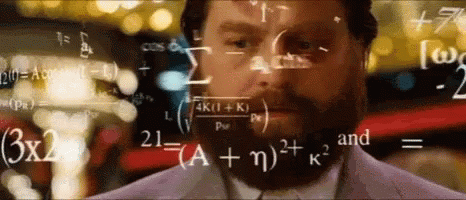

In [21]:
# Instanciate model
model = LogisticRegression(max_iter=1000)
classifier = model.fit(X_train, y_train)

print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       375
           1       0.98      0.98      0.98      3752

    accuracy                           0.97      4127
   macro avg       0.91      0.91      0.91      4127
weighted avg       0.97      0.97      0.97      4127



Excellent job! With a simple logistic regression we can recognize a failure 20 cycles in advance with 98% certainty! 😯

## 📈 Regression baseline

What if we wanted not only to know if the asset is `healthy` or `unhealthy`, but to know more precisely how many cycles it is at the end of its useful life?

This is where regression comes in, not just working with labels but with numbers more specifically.

Let's run it! 🏃

In [22]:
# Evaluation function to calculate our RMSE and R2

def evaluate(y_true, y_hat):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print(f'RMSE:{rmse}, R2:{variance}')

In [23]:
# prep data
# drop unwanted columns
drop_sensors = ['Tag1','Tag5','Tag6','Tag10','Tag16','Tag18','Tag19']
drop_labels = index_names+setting_names+drop_sensors

X = train_data.drop(drop_labels+['RUL', 'label'], axis=1)
y = train_data['RUL']

# And the test dataset
X_test_dataset = test_data.groupby('Asset id').last().reset_index().drop(drop_labels, axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [24]:
# Instantiate the model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict and evaluate
y_hat_train = lm.predict(X_test)
evaluate(y_test, y_hat_train)

RMSE:44.33391060979522, R2:0.5698000071522076


R² can be understood, in a very superficial way, as the explanatory level of the model around the variable that is our target. And the RMSE is the margin of error, in number of runtimes of the "RUL".

So, a simple linear regression model can explain around 56.98%, with a margin of error of up to 44 cycles. 🥶

It doesn't seem very accurate, let's see if we can get better results.

## Data procesing

The next step is to create a model that can predict how many cycles each asset has available until the next failure.

For this, we will prepare the data to be coherent: eliminate sensors that do not add relevant information to the model, reduce the weight of outliers by scaling the data, create polynomial combinations for each feature, and focusing on the final trend that the sensor data presents before failure, rather than considering that the degradation is linear from start to finish (which cannot be observed with such precision).

In [25]:
# prep data
# drop unwanted columns
drop_sensors = ['Tag1','Tag5','Tag6','Tag10','Tag16','Tag18','Tag19']
drop_labels = index_names+setting_names+drop_sensors

X = train_data.drop(drop_labels+['RUL', 'label'], axis=1)
y = train_data['RUL']

# And the test dataset
X_test_dataset = test_data.groupby('Asset id').last().reset_index().drop(drop_labels, axis=1)

In [26]:
# Feature scaling

scaler = MinMaxScaler()

scaler.fit(X)
X_train_scaled = scaler.transform(X)
X_test_dataset_scaled = scaler.transform(X_test_dataset)

In [27]:
# Feature engineering

poly = PolynomialFeatures(2)

X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_dataset_transformed = poly.fit_transform(X_test_dataset_scaled)

Here we can apply a more accurate understanding of what the RUL is from the exploratory analysis, when we observe the degradation in the sensors.

📉 RUL is not linear all the time! It happens at some point in time.

As we do not have more information about what the measurement of the sensors is, I will apply that the regression only starts to be done from the 120th cycle.

In [28]:
# Here we can reformulate our target based only in the final trend of the sensor data, 
# considering only the last 120 cycles

y_clipped = y.clip(upper=120)

In [29]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X_train_transformed, y_clipped, test_size=0.2, random_state=42)

**Annnd ta dããã!**

In [30]:
# Instantiate the model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict and evaluate
y_hat_train = lm.predict(X_test)
evaluate(y_test, y_hat_train)

RMSE:18.763818622288873, R2:0.7729827657293247


The model has a considerable improvement, being able to explain 77% of the variance of the RUL, with 18 cycles of error margin! 🥳

## 🤯 XGBoost

XGBoost is a much more refined and complex model, with great performance for statistical problems, let's try it.

In [31]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

xgb.fit(X_train, y_train)

# predict and evaluate
y_hat_train = xgb.predict(X_test)
evaluate(y_test, y_hat_train)

RMSE:18.33642899230519, R2:0.7832066791831965


We have a improvement in R² (accompanied by a reduction in RMSE). But the great advantage of working with XGBoost is using its hyperparameters, let's run a random search in search of the best values for these parameters:

In [32]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
xgb_model = XGBRegressor(learning_rate=0.1)

#RandomSearch
xgb_random = RandomizedSearchCV(xgb_model,param_dict,verbose=2,cv=5)


xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[14:28:19] WARNING: ../src/learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   2.9s
[14:28:22] WARNING: ../src/learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=5

[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   3.2s
[14:29:04] WARNING: ../src/learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   3.3s
[14:29:07] WARNING: ../src/learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth

[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   1.2s
[14:29:34] WARNING: ../src/learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   1.3s
[14:29:35] WARNING: ../src/learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=6, 

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=N...
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=

**Here we go!**

In [33]:
#Building optimal model on the best estimators
rf_optimal_model = xgb_random.best_estimator_

# make predictions for test data
y_hat_test = rf_optimal_model.predict(X_test)
evaluate(y_test, y_hat_test)

RMSE:17.38761409374267, R2:0.8050620649150194


And again we can see an improvement in efficiency! 🤩

This is our final model: 80% explanation, with a margin of error of 17 cycles. 👌

From this model I will make the prediction for the test dataset and save these values in a .csv file for proper comparison with the true values.

In [34]:
y_hat_test_dataset = rf_optimal_model.predict(X_test_dataset_transformed)

output_data = pd.DataFrame(y_hat_test_dataset) # output de predicted data

output_data.to_csv('../predict/predict.csv', index=False) # and export

# 💡 Conclusion 

* The data allows us to make predictions with a good margin of accuracy.
* The maintenance team can plan their routines more accurately using any of the models (classification or regression).
* There are always trade-offs: the success of using the model is associated with maintenance costs.
* The classification model is, today, more accurate, but it doesn't allow a correct prediction of when the failure will occur.
* The regression model is more suitable in this case, but with a margin of error of 17 cycles, it would not present a great gain, but has an advantage that can be improved over time.


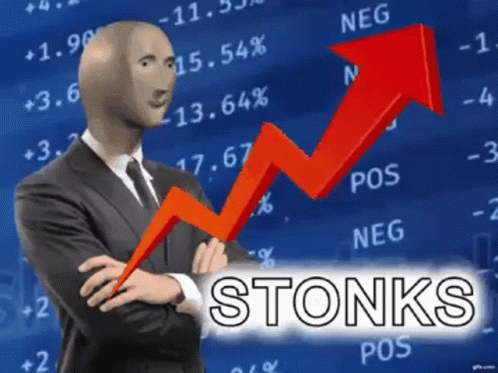